In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
bom_movie_gross = pd.read_csv("../data/bom.movie_gross.csv.gz")

In [6]:
imdb_name_basics = pd.read_csv("../data/imdb.name.basics.csv.gz")

In [7]:
imdb_title_akas = pd.read_csv("../data/imdb.title.akas.csv.gz")

In [8]:
imdb_title_basics = pd.read_csv("../data/imdb.title.basics.csv.gz")

In [9]:
imdb_title_crew = pd.read_csv("../data/imdb.title.crew.csv.gz")

In [10]:
imdb_title_principals = pd.read_csv("../data/imdb.title.principals.csv.gz")

In [11]:
imdb_title_ratings = pd.read_csv("../data/imdb.title.ratings.csv.gz")

In [12]:
rt_movie_info = pd.read_csv("../data/rt.movie_info.tsv.gz", sep='\t')

In [13]:
# rt_reviews = pd.read_csv(data_directory+'rt.reviews.tsv.gz', delimiter = '\t', encoding = 'cp437')

In [14]:
tmdb_movies = pd.read_csv("../data/tmdb.movies.csv.gz")

In [15]:
tn_movie_budgets = pd.read_csv("../data/tn.movie_budgets.csv.gz")

In [16]:
%matplotlib inline

In [17]:
import pandas as pd
data_directory = '../Data/'  
# df_bom = pd.read_csv(data_directory+'bom.movie_gross.csv.gz') #Source: Box Office Mojo
# df_rt_movies = pd.read_csv(data_directory+'rt.movie_info.tsv.gz', delimiter = '\t') #Source: Rotten tomatoes
# df_rt_reviews = pd.read_csv(data_directory+'rt.reviews.tsv.gz', delimiter = '\t', encoding = 'cp437') #Source: Rotten tomatoes 
df_imdb_basics = pd.read_csv(data_directory+'imdb.title.basics.csv.gz') # Source: IMDB
df_imdb_ratings = pd.read_csv(data_directory+'imdb.title.ratings.csv.gz') # Source: IMDB
df_mdb_ratings = pd.read_csv(data_directory+'tmdb.movies.csv.gz') # Source: MovieDB
df_mdb_revenues = pd.read_csv(data_directory+'tn.movie_budgets.csv.gz') # Source: MovieDB

# Creating Lists and Graphs and Things

Instead of using the arbitrary 100000 we will use 25%... 

So I want to first sort by "averagerating", because if we're going to claim to know what type of movie Microsoft Film Studios should make like some kind of mystic, we may as tell them we aim to be compared to the best of the best.  But they also need to have a certain amount of weight, or proof which comes for better or worse throgh "numvotes", because strength in numbers. 

# Plot average rating over the y-axis, movies with greater "numvotes" have a more opaque color whereas the movies with less are transparent. X-Axis displays names? vvvv

In [18]:
# The function cleans the two Movie DB dataframes
def df_clean(data_frame, release_date_column, movie_title_column):
    data_frame.drop_duplicates(keep = 'first', inplace = True)
    if data_frame[release_date_column].dtypes == 'int64':
        data_frame[release_date_column] = pd.to_datetime(data_frame[release_date_column], format = '%Y').dt.to_period("Y") # Assume that movies released in the same month of the same year are the same.
    else:
        data_frame[release_date_column] = pd.to_datetime(data_frame[release_date_column]).dt.to_period("Y") # Assume that movies released in the same month of the same year are the same.
    data_frame[movie_title_column] = [" ".join(title.upper().split()) for title in data_frame[movie_title_column]] # Remove whitespaces
    data_frame[movie_title_column] = [title.replace('Â', "'") for title in data_frame[movie_title_column]] 
    data_frame[movie_title_column] = [title.replace('#', '') for title in data_frame[movie_title_column]] 
    data_frame[movie_title_column] = [title.replace('"', '') for title in data_frame[movie_title_column]]               
    data_frame.drop_duplicates([movie_title_column, release_date_column], keep = False, inplace = True)
    data_frame.sort_values(by = [release_date_column, movie_title_column], ascending = [False, True], inplace = True)
    data_frame.rename(columns={release_date_column: 'release_date', movie_title_column: 'title'}, inplace = True)
    return data_frame

In [19]:
# Merge Movie DB dataframes
df_mdb_ratings.drop('Unnamed: 0', axis = 1, inplace = True) # This is an extra index column
df_mdb_ratings = df_clean(df_mdb_ratings, 'release_date', 'title')
df_mdb_revenues = df_clean(df_mdb_revenues, 'release_date', 'movie')
df_mdb = pd.merge(df_mdb_ratings, df_mdb_revenues, how = 'outer', \
              left_on = ['title', 'release_date'], \
              right_on = ['title', 'release_date'], \
              indicator = True, validate="one_to_one", \
              sort = True)


In [20]:
# Merge IMDB dataframes
df_imdb_basics = df_clean(df_imdb_basics, 'start_year', 'primary_title')
df_imdb = pd.merge(df_imdb_basics, df_imdb_ratings, how = 'outer', \
              on = 'tconst', \
              indicator = True, validate="one_to_one")

In [21]:
# Merge Movie DB and IMDB dataframes
df = pd.merge(df_imdb.drop(columns = '_merge'), df_mdb.drop(columns = '_merge'), how = 'outer', \
              left_on = ['title', 'release_date'], \
              right_on = ['title', 'release_date'], \
              indicator = True, validate="many_to_one", \
              sort = True)
df_merged = df.loc[df._merge == 'both']

In [22]:
df_merged = df.loc[df._merge == 'both']


# Took out any movies that didn't have rating votes in either IMDB or MoviesDB

In [184]:
df_clean = pd.read_csv("export_df_clean.csv")

In [185]:
df_clean.columns

Index(['title', 'release_year', 'genres', 'averagerating', 'numvotes',
       'genre_ids', 'popularity', 'vote_average', 'vote_count',
       'release_year_month', 'production_budget', 'domestic_gross',
       'worldwide_gross', '_merge'],
      dtype='object')

In [186]:
# df_clean["release_year_month"].map(lambda x: len(x.split())).head()

month = []
for movies in df_clean["release_year_month"]:
    if isinstance(movies, str):
        month.append(movies[5:7])
    else:
        month.append("00")
df_clean["month"] = month

In [206]:
df_watched = df_clean.loc[(df_clean["numvotes"] >= 284) & (df_clean["vote_count"] >= 25)]
#Removed all but the top 25% of voted on movies...

In [207]:
df_watched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3861 entries, 36 to 85238
Data columns (total 15 columns):
title                 3861 non-null object
release_year          3861 non-null float64
genres                3861 non-null object
averagerating         3861 non-null float64
numvotes              3861 non-null float64
genre_ids             3861 non-null object
popularity            3861 non-null float64
vote_average          3861 non-null float64
vote_count            3861 non-null float64
release_year_month    3861 non-null object
production_budget     1236 non-null object
domestic_gross        1236 non-null object
worldwide_gross       1236 non-null object
_merge                3861 non-null object
month                 3861 non-null object
dtypes: float64(6), object(9)
memory usage: 482.6+ KB


In [208]:
df_watched.describe()

,release_year,averagerating,numvotes,popularity,vote_average,vote_count
count,3861.000000,3861.000000,3.861000e+03,3861.000000,3861.000000,3861.000000
mean,2014.186221,6.119736,5.386076e+04,9.129434,6.115592,948.374514
std,2.480656,1.106378,1.175098e+05,6.477008,0.973714,2050.440201
min,2010.000000,1.500000,3.020000e+02,0.600000,1.600000,25.000000
25%,2012.000000,5.400000,3.168000e+03,5.421000,5.500000,52.000000
50%,2014.000000,6.200000,9.630000e+03,7.666000,6.100000,155.000000
75%,2016.000000,6.900000,4.550700e+04,10.937000,6.800000,772.000000
max,2018.000000,8.800000,1.841066e+06,80.773000,8.600000,22186.000000


In [249]:
df_watched.shape

(3861, 15)

In [213]:
total_movies_month = df_watched["month"].value_counts()

In [231]:
total_movies_month = total_movies_month.sort_index()

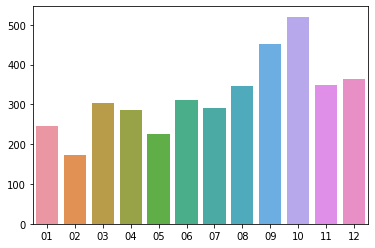

In [246]:
sns.barplot(total_movies_month.index, total_movies_month.values)

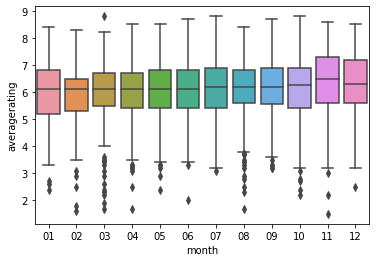

In [248]:
p1=sns.boxplot(x=df_watched["month"], y=df_watched["averagerating"], data=df_watched, order=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"])

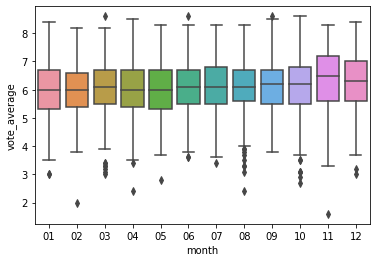

In [247]:
p1=sns.boxplot(x=df_watched["month"], y=df_watched["vote_average"], data=df_watched, order=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"])

In [182]:
df_watched["genres"].unique()

array(['Documentary', 'Action,Adventure,Comedy', 'Comedy', 'Romance',
       'Action,Drama,Thriller', 'Drama,Romance', 'Sport', 'Thriller',
       'Drama', 'Action,Comedy,Crime', 'Documentary,Drama,News',
       'Comedy,Romance', 'Comedy,Music', 'Horror,Sci-Fi,Thriller',
       'Comedy,Drama,Mystery', 'Action,Drama', 'Action,Animation,Sci-Fi',
       'Biography,Documentary,Drama', 'Action,Crime,Drama',
       'Drama,Thriller', 'Documentary,History,Sport',
       'Action,Mystery,Thriller', 'Documentary,Drama', 'Drama,Family',
       'Comedy,Horror,Thriller', 'Drama,Romance,Sport',
       'Adventure,Comedy,Music', 'Horror', 'Action,Animation,Documentary',
       'Drama,War', 'Action,Crime', 'Comedy,Drama,Sci-Fi',
       'Crime,Thriller', 'Drama,Horror,Mystery', 'Comedy,Drama,Musical',
       'Action', 'Crime', 'Comedy,Drama', 'Crime,Mystery,Thriller',
       'Drama,Sport', 'Comedy,Drama,Romance',
       'Adventure,Biography,Documentary', 'Sci-Fi', 'Comedy,Drama,Music',
       'Action,Adv